In [1]:
from sklearn.datasets import load_breast_cancer

# Load the dataset
data = load_breast_cancer()

# Features and labels
X, y = data.data, data.target

y = y.reshape(-1, 1)

In [2]:
# finding if there is misisng data
import numpy as np
print(np.any(np.isnan(X)))

False


In [3]:
# Normalizing data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [4]:
# Splitting data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
import torch.nn as nn

# Define the model
# Simple Feedforward Neural Network
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, general_hidden_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, general_hidden_size)  # Hidden layer with 16 neurons
        self.fc2 = nn.Linear(general_hidden_size, general_hidden_size)  # Hidden layer with 16 neurons
        self.fc3 = nn.Linear(general_hidden_size, 1)  # Output layer (1 neuron)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  # Sigmoid for binary classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [6]:
import torch

model = BinaryClassifier(input_size=30, general_hidden_size = 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
# Print model architecture
print(model)

BinaryClassifier(
  (fc1): Linear(in_features=30, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define loss function
criterion = nn.BCELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

def binary_accuracy(outputs, labels):
    preds = (outputs >= 0.5).float()  # Convert probabilities/logits to 0 or 1
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)


def binary_f1_score(outputs, labels, threshold=0.5):
    preds = (outputs >= threshold).float()  # Convert probabilities to 0 or 1
    tp = (preds * labels).sum().item()  # True Positives
    fp = (preds * (1 - labels)).sum().item()  # False Positives
    fn = ((1 - preds) * labels).sum().item()  # False Negatives
    
    precision = tp / (tp + fp + 1e-8)  # Avoid division by zero
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)  # F1-score formula
    
    return f1



In [8]:
# Lists to store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1, val_f1 = [], []
# Training loop
for epoch in range(1000):  # Set the number of epochs
    print(f"Epoch {epoch+1}/{1000}")
    model.train() # sets the model to training model, Drop layers, BatchNorm are active in training mode

    inputs, labels = torch.Tensor(X_train).to(device), torch.Tensor(y_train).to(device) # moving features and targets to GPU
    optimizer.zero_grad() # Empty gradients
    outputs = model(inputs) # passing inputs through model
    loss = criterion(outputs, labels) # calculating loss
    loss.backward() #  calculate backpropagating updates
    optimizer.step() # applying updates
    _, predicted = torch.max(outputs, 1) # commonly used to determine classtype, _ is the value, predicted is the index of the maximum
    correct = (predicted == labels).sum().item() # calculating correctly predicted number

    train_loss = loss.item() / len(X_train) # calculating train loss
    train_losses.append(train_loss)
    
    train_accuracy = binary_accuracy(outputs, labels)
    train_accuracies.append(train_accuracy)
    
    f1 = binary_f1_score(outputs, labels)
    train_f1.append(f1)

    # Validation phase
    model.eval() # activating evaluation mode, batchnorm and dropouts are deactiavated
    with torch.no_grad(): # doesn't calculate gradients

        inputs, labels = torch.Tensor(X_test).to(device), torch.Tensor(y_test).to(device) # moving features and targets to GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

        val_loss = loss.item() / len(X_test)
        val_accuracy = binary_accuracy(outputs, labels)
        f1 = binary_f1_score(outputs, labels)
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1.append(f1)

    # Apply learning rate scheduler
    scheduler.step(val_loss)


    
    # Print statistics
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch 1/1000
Epoch 1, Train Loss: 0.0015, Train Accuracy: 0.36%, Val Loss: 0.0061, Val Accuracy: 0.38%
Epoch 2/1000
Epoch 2, Train Loss: 0.0015, Train Accuracy: 0.38%, Val Loss: 0.0061, Val Accuracy: 0.39%
Epoch 3/1000
Epoch 3, Train Loss: 0.0015, Train Accuracy: 0.40%, Val Loss: 0.0061, Val Accuracy: 0.40%
Epoch 4/1000
Epoch 4, Train Loss: 0.0015, Train Accuracy: 0.41%, Val Loss: 0.0060, Val Accuracy: 0.41%
Epoch 5/1000
Epoch 5, Train Loss: 0.0015, Train Accuracy: 0.43%, Val Loss: 0.0060, Val Accuracy: 0.46%
Epoch 6/1000
Epoch 6, Train Loss: 0.0015, Train Accuracy: 0.45%, Val Loss: 0.0060, Val Accuracy: 0.48%
Epoch 7/1000
Epoch 7, Train Loss: 0.0015, Train Accuracy: 0.47%, Val Loss: 0.0060, Val Accuracy: 0.51%
Epoch 8/1000
Epoch 8, Train Loss: 0.0015, Train Accuracy: 0.49%, Val Loss: 0.0060, Val Accuracy: 0.54%
Epoch 9/1000
Epoch 9, Train Loss: 0.0015, Train Accuracy: 0.51%, Val Loss: 0.0059, Val Accuracy: 0.58%
Epoch 10/1000
Epoch 10, Train Loss: 0.0015, Train Accuracy: 0.57%, Val Lo

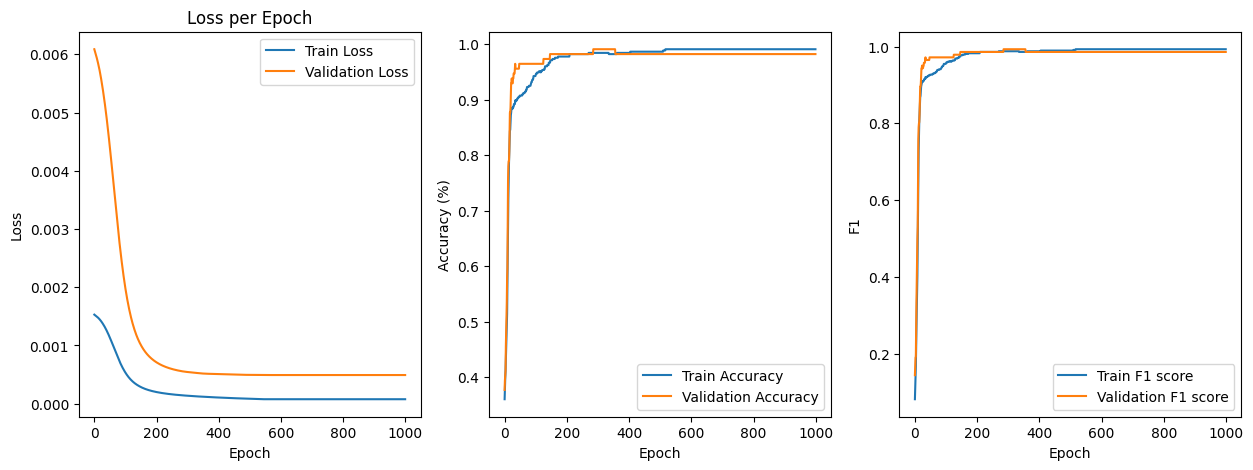

In [9]:
from matplotlib import pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')

# Plot training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 3, 3)
plt.plot(train_f1, label='Train F1 score')
plt.plot(val_f1, label='Validation F1 score')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()